# Bikes sharing training        

#### Descripton
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

#### Steps:
 1. import data
 1. what are parameters mean
 1. preprocess data
    1. work with boolean and categorical parameters
    1. scale real parameters
    1. drop out redundant parameters
 
 

#### Data Fields

+ **datetime** - hourly date + timestamp  
+ **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
+ **holiday** - whether the day is considered a holiday
+ **workingday** - whether the day is neither a weekend nor holiday
+ **weather**:
    + 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    + 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    + 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    + 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
+ **temp** - temperature in Celsius
+ **atemp** - "feels like" temperature in Celsius
+ **humidity** - relative humidity
+ **windspeed** - wind speed
+ **casual** - number of non-registered user rentals initiated
+ **registered** - number of registered user rentals initiated
+ **count** - number of total rentals

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing


In [2]:
plt.style.use(['classic', 'fivethirtyeight','seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (10,4)

In [3]:
raw_data = pd.read_csv('data/bike_sharing_demand.csv')
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


look at NaN values

In [4]:
print('Null values in the dataframe: ', raw_data.isnull().values.any())

Null values in the dataframe:  False


parameters 'casual' and 'registered' are trivial and returns target parameter 'count' by adding in all cases

In [5]:
np.all(raw_data['casual'] + raw_data['registered'] == raw_data['coun'])

True

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


convert datetime object to month day and time

In [7]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [8]:
raw_data['month'] = [x.month for x in raw_data.datetime]
raw_data['day'] = [x.day for x in raw_data.datetime]
raw_data['hour'] = [x.hour for x in raw_data.datetime]

Create control_set

In [9]:
train_data = raw_data.iloc[:-1000, :]
control_data = raw_data.iloc[-1000:, :]

Create dataset by dropping out redundant features and datetime index

In [10]:
train_labels = train_data['count']
train_data = train_data.drop(['casual', 'registered', 'count', 'datetime'], axis='columns')

In [11]:
control_labels = control_data['count']
control_data = control_data.drop(['casual', 'registered', 'count', 'datetime'], axis='columns')

In [12]:
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,4


Distribution of labels in train and control data (good if same)

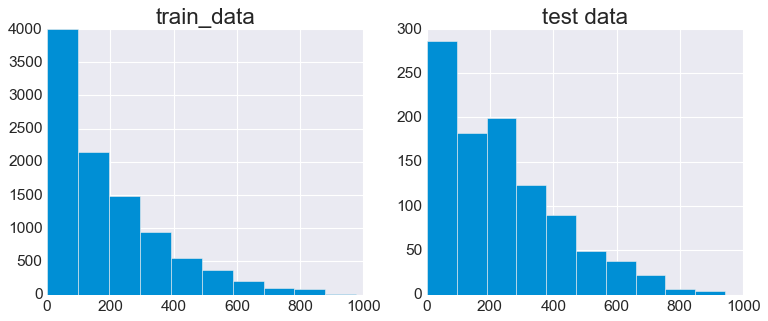

In [13]:
plt.subplot(1,2,1)
plt.hist(train_labels);
plt.title('train_data')

plt.subplot(1,2,2)
plt.hist(control_labels)
plt.title('test data');

Define numerical, categorical and bollean features

In [39]:
num_feat_cols  = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
num_feat_inds = np.array([col in num_feat_cols for col in train_data.columns])

In [41]:
cat_feat_cols = ['season', 'weather', 'month', 'day']
cat_feat_inds = np.array([col in cat_feat_cols for col in train_data.columns])

In [43]:
bool_feat_cols = ['holiday', 'workingday']
bool_feat_inds = np.array([col in bool_feat_cols for col in train_data.columns])

### Pipeline

several regressors for grid_search

In [99]:
regressor = linear_model.SGDRegressor()
regressor2 = linear_model.HuberRegressor()

main pipeline of features preprocessing step and regessor choosing step

In [54]:
estimator = pipeline.Pipeline(steps=[
    # preprocessing features
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        # boolean features
        ('bool', preprocessing.FunctionTransformer(lambda data: data[:, bool_feat_inds])),
        # categorical features
        ('cat', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, cat_feat_inds])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
        ])),
        # numerical features
        ('num', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, num_feat_inds])),
            ('scaling', preprocessing.StandardScaler())
        ]))
    ])),
    # estimating model
    ('model_fitting', regressor)
])

### Estimating of default SGDRegressor with default params

In [55]:
estimator.fit(train_data, train_labels)

/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('bool', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1a2285fd08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('cat', Pip...      power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

### evaluate default estimating

In [93]:
np.sqrt(metrics.mean_squared_error(control_labels, estimator.predict(control_data)))

179.4432122531531

In [94]:
metrics.mean_absolute_error(control_labels, estimator.predict(control_data))

121.48914340050605

### try grid search to find best hyperparameters

In [62]:
for key in estimator.get_params().keys():
    if modelprint(key)

memory
steps
feature_processing
model_fitting
feature_processing__n_jobs
feature_processing__transformer_list
feature_processing__transformer_weights
feature_processing__bool
feature_processing__cat
feature_processing__num
feature_processing__bool__accept_sparse
feature_processing__bool__func
feature_processing__bool__inv_kw_args
feature_processing__bool__inverse_func
feature_processing__bool__kw_args
feature_processing__bool__pass_y
feature_processing__bool__validate
feature_processing__cat__memory
feature_processing__cat__steps
feature_processing__cat__selecting
feature_processing__cat__hot_encoding
feature_processing__cat__selecting__accept_sparse
feature_processing__cat__selecting__func
feature_processing__cat__selecting__inv_kw_args
feature_processing__cat__selecting__inverse_func
feature_processing__cat__selecting__kw_args
feature_processing__cat__selecting__pass_y
feature_processing__cat__selecting__validate
feature_processing__cat__hot_encoding__categorical_features
feature_pro

params_grid for SGDRegressor

In [70]:
parameters_grid = {
    'model_fitting__alpha' : [0.01, 1, 10, 100],
    'model_fitting__max_iter' : [3, 5, 10, 50],
    'model_fitting__penalty' : ['l1', 'l2', 'elasticnet'],
    'model_fitting__l1_ratio' : np.arange(0.1,1,0.2)
}

grid of regressors

In [100]:
est_grid = {
    'model_fitting' : [regressor, regressor2]
}

first grid_cv to find best farams ofr SGDRegressor

In [73]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring='neg_mean_absolute_error', cv=10)

Second grid too compare SGD and Huber regressors

In [101]:
grid_cv2 = model_selection.GridSearchCV(estimator, est_grid, scoring='neg_mean_absolute_error', cv=4)

### Fitting the model

In [75]:
%time grid_cv.fit(train_data, train_labels)

CPU times: user 1min 39s, sys: 1.61 s, total: 1min 41s
Wall time: 1min 41s


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('bool', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1a2285fd08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('cat', Pip...      power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model_fitting__alpha': [0.01, 1, 10, 100], 'model_fitting__max_iter': [3, 5, 10, 50], 'model_fitting__penalty': ['l1', 'l2', 'elasticnet'], 'model_fitting__l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [102]:
%time grid_cv2.fit(train_data, train_labels)

/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), Fut

CPU times: user 3.02 s, sys: 72 ms, total: 3.09 s
Wall time: 1.07 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('bool', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1a2285fd08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('cat', Pip...      power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model_fitting': [SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False), HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)]},
     

In [96]:
grid_cv.best_params_

{'model_fitting__alpha': 1,
 'model_fitting__l1_ratio': 0.30000000000000004,
 'model_fitting__max_iter': 50,
 'model_fitting__penalty': 'elasticnet'}

In [104]:
grid_cv2.best_params_

{'model_fitting': HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
         tol=1e-05, warm_start=False)}

In [105]:
best_SGDestimator = grid_cv.best_estimator_

In [107]:
best_huber_estimator = grid_cv2.best_estimator_

In [110]:
print(grid_cv.best_score_)
print(grid_cv2.best_score_)

-108.20126810585019
-111.1566974280412


In [117]:
print('MAE SGD: ', metrics.mean_absolute_error(control_labels, best_SGDestimator.predict(control_data)))
print('MAE Huber: ', metrics.mean_absolute_error(control_labels, best_huber_estimator.predict(control_data)))

MAE SGD:  139.91912463071276
MAE Huber:  127.05928805923831


## Random Forest

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
rf_reg = RandomForestRegressor()

In [120]:
rf_reg.fit(train_data, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [122]:
print('MAE RandomForest: ', metrics.mean_absolute_error(control_labels, rf_reg.predict(control_data)))

MAE RandomForest:  80.28760000000001


## Comparing three types of regression

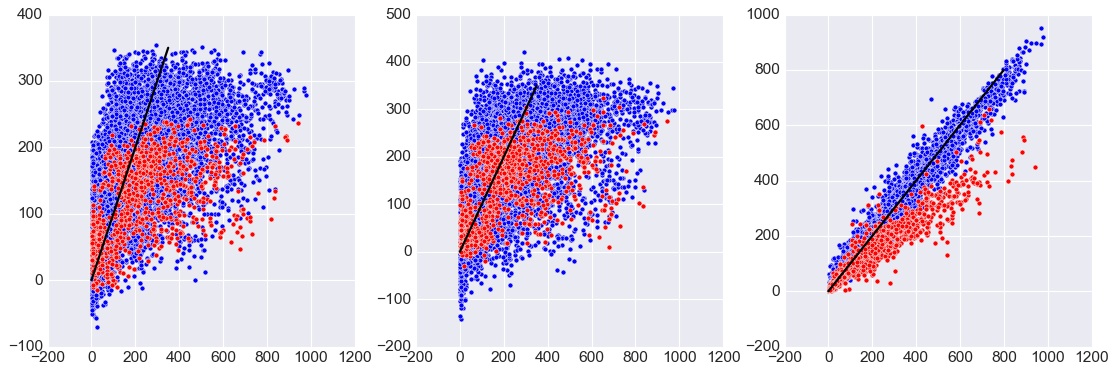

In [154]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(train_labels, best_SGDestimator.predict(train_data))
plt.scatter(control_labels, best_SGDestimator.predict(control_data), c='r');
plt.plot([0,350], [0,350], c='k', lw=2);

plt.subplot(1,3,2)
plt.scatter(train_labels, best_huber_estimator.predict(train_data))
plt.scatter(control_labels, best_huber_estimator.predict(control_data), c='r');
plt.plot([0,350], [0,350], c='k', lw=2);

plt.subplot(1,3,3)
plt.scatter(train_labels, rf_reg.predict(train_data))
plt.scatter(control_labels, rf_reg.predict(control_data), c='r')
plt.plot([0,800], [0,800], c='k', lw=2);
